<a href="https://colab.research.google.com/github/Soumedhik/Blind-Aid-Intel_OneApi_Hackathon/blob/main/Currency_Pred_RESNET50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'resnet50:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F6209%2F9900%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240329%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240329T214509Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D77b03f0e77febc3542b6ab1238d0672a66b379b72fb8cc5ba106d11ce827f4e2519fa23396422c2ddd0157166273dbb9aff3454f3192a2099a9ef860d7d27fa97d0f896379b0006e6bab0559afe7a8a2eba8c66f3278b747130a8e8be08c1d6f709555456619b8019cd51bf52e584d84aa69f7e6826c3d7b94262088988a18a3d87e04d60cf1905ccef2c37b2c0e9ee83aec1940fa863a41f553596425b319fcf3eb46cfa1148f185a3a8947fa38986cc5ca1bfe16b0feddd9320db8f1916b497c366e14eaf36fea7be331211c7407b730aed902d312083d9ab85bf5bbddf851dcb33468547b9ca4928c8e39698e6a48c1fe37cd72bce063c9ad1719c52aa2bb,indian-currency-note-images-dataset-2020:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F886101%2F1505106%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240329%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240329T214509Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2945f21b7619eff67f5e0550657afde52f17d3ebdc50b3e0d8dc037f05a8abc653704e4fa6b6900be96e992b4319574cb4c673349f7f374431a3762d6311c2b32ec2f951fee6e8b959d3e0eeae4ce2aa46564530b06605bd64cde02987cb6f833e86536d61bc47a626a783beb4339bed498306d42ad65f053cbac971c3bce4e366962af7d2ea9233112c0c86d9f948b0333e5cb0afa5be271f13ec80bad6d399a7a4542c25961ce7d7a48da56fd586e97ff93832048ed7b942a168dad5f74de2e5cc5511f0c25932bc9f9576226e5407ed0cc0596b0c4377462df6248c87f1421d8f76bed204dc60af32ed59b463f411900bf3a8586df8124cc058dc546bc7a8,indian-currency-note-resnet-weights:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F886652%2F1505707%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240329%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240329T214509Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0eda4c698f364833130a0f62e8d88b1d3a68c4cf6c6d499d0d248248ffd9c6289f50932a787f35fe67e95f4372aca7f95dbbe54806389de6cbbe5fb593fa7e030dc30a959c1e1ac971952cf4b715c1f203576a2a1330cd71dabab508ee003e01bad5ab2d7eb5f397b22fd22eecf111e995bff261045a1fb6cf283fd70fc4c84c816b094d56944d8c73b00fd3f6259159d1978adfedaa7b84a84764f0cd4dacd378b6b24ce93a6c72a518c8d292aa6525cbb7e4f343c539c29bb843a2a8cef5e0104a162e2926fef43788c0fde9f9feaf95c48238bf3fd8ec19801b7ce1ed5f909aa95feb3f1f8cf41702d431d3312148eb703f2179aad421c27c9dfdf40fb2d7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 182711136 bytes downloaded
Downloaded and uncompressed: resnet50
[==================================================] 2482345188 bytes downloaded
Downloaded and uncompressed: indian-currency-note-images-dataset-2020
[==================================================] 87709370 bytes downloaded
Downloaded and uncompressed: indian-currency-note-resnet-weights
Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resnet50/imagenet_class_index.json
/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5
/kaggle/input/indian-currency-note-images-dataset-2020/Indian currency dataset v1/test/100__371.jpg
/kaggle/input/indian-currency-note-images-dataset-2020/Indian currency dataset v1/test/500__289.jpg
/kaggle/input/indian-currency-note-images-dataset-2020/Indian currency dataset v1/test/Background__309.jpg
/kaggle/input/indian-currency-note-images-dataset-2020/Indian currency dataset v1/test/500__114.jpg
/kaggle/input/indian-currency-note-images-dataset-2020/Indian currency dataset v1/test/2000__114.jpg
/kaggle/input/indian-currency-note-images-dataset-2020/Indian currency dataset v1/test/100_3.jpg
/kaggle/input/indian-currency-note-images-dataset-2020/Indian currency dataset v1/test/10__324.jpg
/kaggle/input/indian-currency-note-images-dataset-2020/Indian currency dataset v1/test/20__324.jpg
/k

In [4]:
pip install path

In [5]:
#import basic essential libraries
import matplotlib.pyplot as plt
import path
import os
%matplotlib inline

# import  keras libraries to build model and conv net
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten
from pathlib import Path

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


data_agumentation=ImageDataGenerator(rescale=0./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True

)


In [7]:
from tensorflow.keras.models import load_model

model=load_model('../input/indian-currency-note-resnet-weights/currency_detector_2.4GB_earlyStopping_model.h5')

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

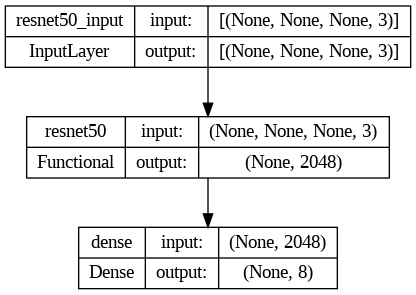

In [9]:
from tensorflow.keras.utils import plot_model
# Display the model diagram
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

In [10]:
from keras.preprocessing import image
class_labels = [
    '10','100','20','200','2000','50','500','Background'
]

def prediction(file_name):
    img = image.load_img(file_name, target_size=(256,256))

    image_to_test = image.img_to_array(img)

    # Since Keras expects a list of images, not a single image,
    # Add a fourth dimension to the image
    list_of_images = np.expand_dims(image_to_test, axis=0)

    # Make a prediction using the model
    results = model.predict(list_of_images)

    # Since we are only testing one image, we only need to check the first result
    single_result = results[0]

    # We will get a likelihood score for all possible classes.
    # Find out which class had the highest score.
    # The class with the highest likelihood is predicted as the result.
    most_likely_class_index = int(np.argmax(single_result))
    class_likelihood = single_result[most_likely_class_index]

    # Get the name of the most likely class
    class_label = class_labels[most_likely_class_index]

    # Print the result
    print(file_name)
    print("This image is predicted as a {} with a likelihood of {:.2f}".format(class_label, class_likelihood))


In [11]:
prediction("/content/360_F_356320611_FcuF3JcK9DIkAAPS8kbtHxZx8iS4Je8P.jpg")

FileNotFoundError: [Errno 2] No such file or directory: '/content/360_F_356320611_FcuF3JcK9DIkAAPS8kbtHxZx8iS4Je8P.jpg'

In [12]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [13]:
%%writefile app.py
import streamlit as st
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('../input/indian-currency-note-resnet-weights/currency_detector_2.4GB_earlyStopping_model.h5')
class_labels = ['10', '100', '20', '200', '2000', '50', '500', 'Background']

def predict_currency(image_file):
    img = image.load_img(image_file, target_size=(256, 256))
    image_to_test = image.img_to_array(img)
    list_of_images = np.expand_dims(image_to_test, axis=0)
    results = model.predict(list_of_images)
    most_likely_class_index = int(np.argmax(results[0]))
    class_likelihood = results[0][most_likely_class_index]
    class_label = class_labels[most_likely_class_index]
    return class_label, class_likelihood

def main():
    st.title("Indian Currency Note Detector")
    uploaded_file = st.file_uploader("Upload an image of an Indian currency note", type=["jpg", "jpeg", "png"])

    if uploaded_file:
        class_label, class_likelihood = predict_currency(uploaded_file)
        st.image(uploaded_file, caption=f"Predicted as {class_label} with likelihood {class_likelihood:.2f}")
        st.write(f"This image is predicted as a {class_label} with a likelihood of {class_likelihood:.2f}")

if __name__ == "__main__":
    main()


Writing app.py


In [14]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 2.482s

3 packages are looking for funding
  run `npm fund` for details

found 1 moderate severity vulnerability
  run `npm audit fix` to fix them, or `npm audit` for details


In [15]:
! wget -q -O - ipv4.icanhazip.com

34.73.38.231


In [99]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.73.38.231:8501

npx: installed 22 in 2.386s
your url is: https://late-oranges-ask.loca.lt
2024-03-30 09:39:32.426210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 09:39:32.426280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 09:39:32.431296: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-30 09:39:33.979403: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-03-30 09:40:28.642 Unc

In [17]:
!pip install git+https://github.com/openai/whisper.git

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-03n1bt9z
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-03n1bt9z
  Resolved https://github.com/openai/whisper.git to commit ba3f3cd54b0e5b8ce1ab3de13e32122d0d5f98ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:0

In [18]:
!pip install --upgrade --no-deps --force-reinstall git+https://github.com/openai/whisper.git

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-exaa8uzn
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-exaa8uzn
  Resolved https://github.com/openai/whisper.git to commit ba3f3cd54b0e5b8ce1ab3de13e32122d0d5f98ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20231117-py3-none-any.whl size=802826 sha256=9381ccc27135953d53c2bddd4fb276e799208bafdb63c57b8dc1d2b7f7575bea
  Stored in directory: /tmp/pip-ephem-wheel-cache-zix3aepp/wheels/8b/6c/d0/622666868c179f156cf595c8b6f06f88bc5d80c4b31dccaa03
Successfully built openai-whisper
  Attempting uninstall: openai-whisper
    Found existing installation: openai-whisper 20231117
    Uninstalling openai-whisper-20231117:
      Successfully uninstalled openai-whisper-20231117


In [19]:
!sudo apt update && sudo apt install ffmpeg

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,920 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,358 kB]
Fetched 3,510 kB in 2s (2,287 kB/s)
Reading package lists... Do

In [29]:
!whisper "/content/Recording.m4a" --model base

/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
Detecting language using up to the first 30 seconds. Use `--language` to specify the language
Detected language: English
[00:00.000 --> 00:02.000]  CD, find me 140 rupees.


In [46]:
import subprocess
import re

# Transcribe the audio using Whisper
audio_file = "/content/Recording.m4a"
transcription = subprocess.check_output(["whisper", audio_file, "--model", "base", "--word_timestamps", "True"]).decode("utf-8")

# Extract the number mentioned after "find me"
match = re.search(r'find me (\d+)', transcription)
if match:
    number = int(match.group(1))
    print("Extracted number:", number)
else:
    print("No number found in the transcription.")


Extracted number: 140


In [98]:
# Step 1: Create the array of tuples with duplicate denominations
original_array = []
total_amount = int(input("Enter the total amount of notes: "))
for _ in range(num_notes):
    uploaded_file = st.file_uploader("Upload an image of an Indian currency note", type=["jpg", "jpeg", "png"])
    if uploaded_file:
            img = image.load_img(image_file, target_size=(256, 256))
            image_to_test = image.img_to_array(img)
            list_of_images = np.expand_dims(image_to_test, axis=0)
            results = model.predict(list_of_images)
            most_likely_class_index = int(np.argmax(results[0]))
            class_likelihood = results[0][most_likely_class_index]
            class_label = class_labels[most_likely_class_index]
            original_array.append(int(class_label))
indexed_array = [(value, index + 1) for index, value in enumerate(original_array)]

# Step 2: Sort the array based on the first element of each tuple (the value) in descending order
sorted_array = sorted(indexed_array, key=lambda x: x[0], reverse=True)

total_amount = int(input("Enter the total amount: "))

# Step 3: Initialize variables to track the total and the notes included
remaining_amount = total_amount
included_notes = []

# Step 4: Iterate through the sorted array and calculate the best denominations
for denomination, index in sorted_array:
    count = remaining_amount // denomination
    if count > 0:
        included_notes.extend([(denomination, index)] * count)
        remaining_amount %= denomination

# Step 5: Display the included notes with their original positions
print("Denominations:")
for denomination, index in included_notes:
    print(f"Note of {denomination} rs from position {index}")

# Step 6: Display the remaining change (if any)
if remaining_amount > 0:
    print(f"Remaining change: {remaining_amount} rs")

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 8)